<a href="https://colab.research.google.com/github/NatalyaEvans/ETNP_stoich/blob/main/pyompa_scripts/ETNP_pyompa_for_WOD_USER_FRIENDLY_BASE_VERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ETNP_pyompa_for_WOD_USER_FRIENDLY_BASE_VERSION

Written by Natalya Evans

This script is built to perform an eOMP on the ETNP ODZ data from the WOD18 to determine variations in the stoichiometry of anaerobic remineralization. This stoichiometry can then be used to solve for the percent of nitrite re-oxidation. It was written during revisions for the paper "Prolific nitrite re-oxidation across the Eastern Tropical North Pacific Ocean" (https://www.essoar.org/doi/10.1002/essoar.10511252.1). 

This version of the code is significant because I designed it as a go-to template for performing water mass analysis with pyompa. It is designed to run in a google drive folder, where it reads in csv files from that same folder and writes a csv output to that folder. Other scripts for this project are designed to use Github, which allows them to access a repository and have superior version control. Unfortunately, this also adds Github familiarity as a potential barrier for new users. This code only requires setting up a google drive folder, which we anticipate may be more intuitive. 

For this code to run on a different computer in google colab, follow the steps below:

1. Replace te beginning of the URL that says "https://github.com/" with "https://colab.research.google.com/github/". This step should open the notebook in colab, if your google account has that set up. Some institutions don't have colab enabled, but a person gmail should.

2. Add a copy of this file to your google drive with the "Copy to Drive" button on top. Locate the folder where the copy was saved by going to "File" -> "Locate in Drive". It will likely be in the folder called "Colab Notebooks".

3. Put the csv files "WOD_ETNP_pyompa_2_reduced.csv" and "ETNP_pyompa_ref_values.csv" into this folder. These consist of the data to analyze and the endmembers, appropriately.

4. Adjust the working folder with the line that starts with "%cd ". This changes the directory. Everything after the entry "MyDrive" is a subfolder, so if this file is in the folder Colab Notebooks, then change this to say 
%cd "/content/drive/MyDrive/Colab Notebooks"

5. 



Comment this more and put on github

In [ ]:
# install pyompa to do the analysis and gsw for helpful interconversions
!pip install pyompa==0.4.2.0
!pip install gsw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount the google drive folder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pwd # show working directory
%cd "/content/drive/MyDrive/pyompa/ETNP WOD pyompa"
!ls

/content/drive/MyDrive/pyompa/ETNP WOD pyompa
ETNP_df_ompasoln.csv	    WOD_cleaned.csv
ETNP_pyompa_for_WOD.ipynb   WOD_ETNP_pyompa_2.csv
ETNP_pyompa_ref_values.csv  WOD_ETNP_pyompa_2_reduced.csv
pyompa_plotter_reox.m


In [ ]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np


232024

Load the data to analyze

In [ ]:
data_df = pd.read_csv("WOD_ETNP_pyompa_2_reduced.csv") # read in the data to be analyzed. This data file already has the values outside of the analysis region removed

Define the endmembers. Column headers here have to match those of the data being analyzed

In [ ]:
endmembers_df_read = pd.read_csv("ETNP_pyompa_ref_values.csv")

In [ ]:
endmembers_df_read.head() # check it worked

,Params,CT,SA,Phosphate,Nitrate,Silicate,tCO2,pdens,Notes
0,13CW,13.410,34.95,2.33,29.99,23.50,2235,26.29,Adjusted to a more centered point in intersection
1,NEPIW,9.470,34.78,2.65,35.60,33.86,2270,26.74,NaN
2,AAIW,5.530,34.70,3.13,43.21,83.68,2323,27.25,"Shifted to on the intersection, rather than th..."
3,uPSUW,7.765,32.96,1.13,10.07,11.40,2235,25.60,NaN
4,13CW2,13.410,34.95,2.31,31.79,23.98,2281,26.29,NaN


Remove the endmembers we won't be using

In [ ]:
endmembers_df = endmembers_df_read.iloc[[0,1,2]] # defines a new dataframe so we can cut and then adjust without re-reading in the data

endmembers_df.head() # check that this selection is correct. When calling "head", only 5 rows will be displayed.

,Params,CT,SA,Phosphate,Nitrate,Silicate,tCO2,pdens,Notes
0,13CW,13.41,34.95,2.33,29.99,23.50,2235,26.29,Adjusted to a more centered point in intersection
1,NEPIW,9.47,34.78,2.65,35.60,33.86,2270,26.74,NaN
2,AAIW,5.53,34.70,3.13,43.21,83.68,2323,27.25,"Shifted to on the intersection, rather than th..."


Define the pyompa parameters and run the eOMP analysis

In [ ]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc # this is specifically to have a penalty

# converted parameters contains the remineralization stoichiometries. Each group
# corresponds to a remineralization process, and in the ETNP ODZ, we have two: 
# aerobic and anaerobic remineralization. The names in the conversion ratio have
# to match the input data and the endmembers. Adding multiple entries within the
# "conversion ratios" setting enables flexible remineralization. In this case, I
# have two entries for both (an)aerobic remineralizations, meaning that both are
# flexible. Each remineralization also has an option called "always_positive", 
# which is used to determine if this remineralization can only be applied in the
# positive direction. For aerobic remineralization, if always_positive=True, 
# then the solver algorithm can only allow remineralization to occur. However,
# if always_positive=False, then both remineralization and nutrient assimilation
# can occur.

convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="aerobic_remin",
        conversion_ratios=[{"Phosphate": 1.0, "Nitrate": 14, "Silicate": 12, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": 17, "Silicate": 48, "tCO2": 118}],
        always_positive=False 
        ),pyompa.ConvertedParamGroup(
        groupname="anaerobic_remin",
        conversion_ratios=[
        {"Phosphate": 1.0, "Nitrate": -40, "Silicate": 15, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": -65, "Silicate": 48, "tCO2":118}
        ],
        always_positive=True 
        )
]

# usage penalties are applied to prevent the algorithm from assigning a water 
# mass in specific conditions. These are most often spatially limiting. For 
# example, if a water mass is limited with regards to its latitude, longitude, 
# or potential density, but the eOMP solution includes this water mass outside 
# those bounds, a usage penalty can be applied. There are both soft and hard 
# penalties. I'm using a soft one below.

usage_penalty = { 
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

# These are the weighting for each parameter.
paramweightings = {
    "CT": 12.0,
    "SA": 8.0,
    "Phosphate": 6.0,
    "Nitrate": 4.0,
    "tCO2": 4.0,
    "Silicate": 2.0
}

# The settings command specifies the objects for each part of the pyompa. In 
# param_names, these are the names of the parameters that are being used in the
# pyompa. We then specify the weightings and the remineralization. Next, there 
# are two options for comparing this package with the matlab omp2 package 
# written by Mattias Tomczak and Johannes Karstensen. In pyompa, we typically 
# set "sumtooneconstraint" to True to enforce a hard mass constraint, then set
# standardize_by_watertypes" to False to ensure that changing water mass 
# endmembers does not vary the weightings. If you want this pyompa script to be
# backwards compatible, do the opposite of those two commands.

settings = {
    "param_names": ["CT", "SA",
                    "Phosphate", "Nitrate",
                    "Silicate"
                    ,"tCO2"
                    ],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False}

#Run the analysis here. The analysis problem and solution is stored within the
# "ETNP_df_ompasoln" object.

ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = data_df,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      endmembers_df,
      endmember_name_column="Params")
  
# ** notation uses a python dictionary and maps the keys in that dict to the parameter names, shorthand parameter specs onto a dictionary

Dropping 6 rows that have NA values in the observations
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [12.  8.  6.  4.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 47499.8199427904
Original weighted sum squares: 47499.722722814666
Post fix weighted sum squared: 47500.51053350982
Trying convertedvariable sign constraint: [-1 -1  1  1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 153595.2774665839
Original weighted sum squares: 153594.97496941237
Post fix weighted sum squared: 153595.1601792468
On example 0 to 1220 out of 1220
status: optimal
optimal value 18470.820781074537
Original weighted sum squares: 18470.685525267363
Post fix weighted sum squared: 18470.905577328624
objective: 18470.905577328624



Load in plotting tools

In [ ]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

Plot results

Water mass fractions and deltaP


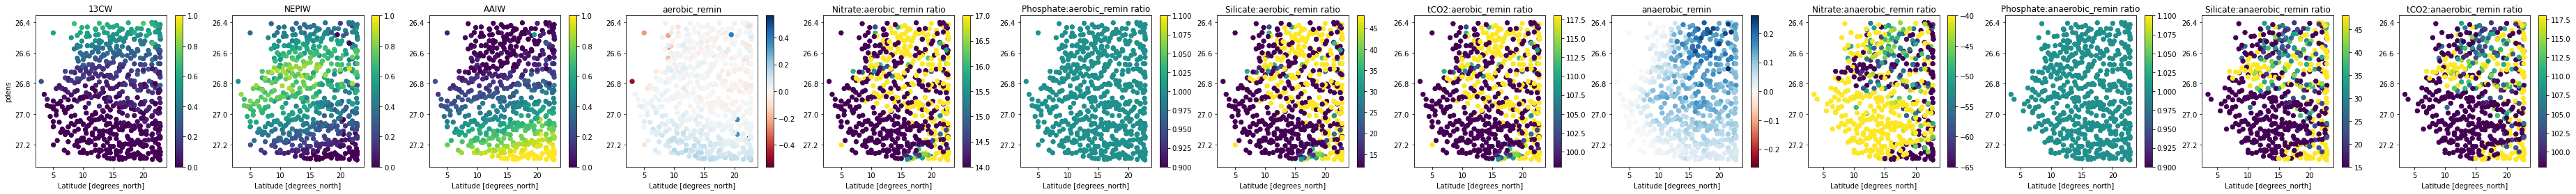

In [ ]:
xaxis_colname="Latitude [degrees_north]"

yaxis_colname = "pdens"
print("Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname=xaxis_colname,
                                  yaxis_colname=yaxis_colname)


Plot residuals

Residuals


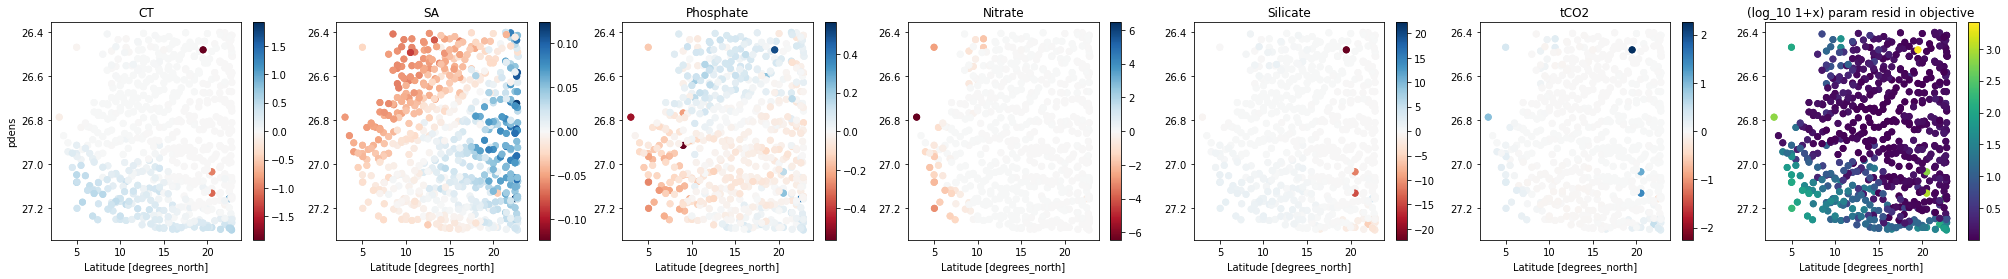

In [ ]:
print("Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname=xaxis_colname,
                        yaxis_colname=yaxis_colname)

Output the pyompa sol'n as a csv into the drive folder this script currently is in. Then, we're done!




In [ ]:
from collections import OrderedDict

ORIG_COLS_TO_INCLUDE = list(data_df.columns.values) # all of the columns. A subset can be used instead if so desired.
ETNP_df_ompasoln.export_to_csv(
    csv_output_name="ETNP_df_ompasoln_single.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)



writing to ETNP_df_ompasoln.csv
